## Task: Expiring but Not Cancelled Subscriber Churn Pridiction

### Churn Definition:
Subscribers at the end of each month who expired at the next month.

### Expiring but Not Cancelled Subscriber
For subscribers who:
- expiration date on the next month
- auto renew = true (havn’t cancel)

Predict if the subscriber will truely expired or not (no matter manual cancel or force cancel)
Calculate in Monthly basis (to sync with current churn rate calculation)

### Libraries

In [1]:
# machine learning library
import sklearn # https://scikit-learn.org/stable/

# linear algebra
import numpy as np # https://numpy.org/

# data processing
import pandas as pd # https://github.com/pandas-dev/pandas

dataframe

In [43]:
df = pd.read_csv('user_feature_collection.csv')
df.shape

(71447, 46)

In [41]:
df.is_cancelled_next_month.value_counts()

False    68352
True      3095
Name: is_cancelled_next_month, dtype: int64

In [42]:
df.describe

<bound method NDFrame.describe of       snapshot_date    account_id account_country        register_datetime  \
0        2022-05-31  HQ0RHR5NDBE9              US  2020-10-12 16:21:30.000   
1        2022-05-31  HQ0RHR5NJ67B              US  2021-05-01 12:27:20.000   
2        2022-05-31  HQ0RHR5NHBOT              CA  2021-01-12 20:54:15.000   
3        2022-05-31  HQ0RHR5NI3XE              US  2021-03-09 07:45:19.000   
4        2022-05-31  HPRXDMQ639FS              US  2019-12-03 21:19:58.000   
...             ...           ...             ...                      ...   
71442    2022-05-31  HPRXDMQ63US6              US  2019-12-14 21:58:38.000   
71443    2022-05-31  HPRXDMQ63AFL              US  2019-12-04 01:06:13.000   
71444    2022-05-31  HQ47B24X8BZN              US  2021-06-09 01:55:08.000   
71445    2022-05-31  HQ47B24XBPV6              US  2021-12-04 15:14:07.000   
71446    2022-05-31  HPOFIMN0O1FZ              US  2018-10-10 04:02:55.000   

       pet_count  max_pet_age

### Data Preprocessing and Feature Selection
Transfer non-numeric column to numbers

#### Datetimes

In [5]:
# Register Date
df['register_month'] = df.register_datetime.astype('datetime64[ns]').dt.month.astype('str')
df['registered_days'] = (df.snapshot_date.astype('datetime64[ns]') - df.register_datetime.astype('datetime64[ns]')).dt.days

# Camera Setup Date
df['max_camera_setup_days'] = (df.snapshot_date.astype('datetime64[ns]') - df.first_camera_setup_datetime.astype('datetime64[ns]')).dt.days
df['min_camera_setup_days'] = (df.snapshot_date.astype('datetime64[ns]') - df.last_camera_setup_datetime.astype('datetime64[ns]')).dt.days

# Trial Date
df['first_trial_month'] = df.first_trial_start_datetime.astype('datetime64[ns]').dt.month.fillna(0).astype('str')
df['last_trial_month'] = df.last_trial_start_datetime.astype('datetime64[ns]').dt.month.fillna(0).astype('str')
df['fdn_experience_age'] = (df.snapshot_date.astype('datetime64[ns]') - df.first_trial_start_datetime.astype('datetime64[ns]')).dt.days

# Subscription
df['first_subscribe_month'] = df.first_subscription_start_datetime.astype('datetime64[ns]').dt.month.fillna(0).astype('str')
df['last_subscribe_month'] = df.last_subscription_start_datetime.astype('datetime64[ns]').dt.month.fillna(0).astype('str')
df['subscription_period'] = (df.subscription_expire_datetime.astype('datetime64[ns]') - df.subscription_start_datetime.astype('datetime64[ns]')).dt.days
df['fdn_remain_days'] = (df.subscription_expire_datetime.astype('datetime64[ns]') - df.snapshot_date.astype('datetime64[ns]')).dt.days


#### Nominal Variables: 1/0, One-hot Encoding (For Linear), Label Encoding 

In [6]:
# is_cancelled_next_month: True/False
df.is_cancelled_next_month = df.is_cancelled_next_month.astype(int)

# One-hot Encoding
df_category = df[['account_country', 'subscription_plan_id', 'register_month', 'first_trial_month', 'last_trial_month', 'first_subscribe_month', 'last_subscribe_month']]
df_category_one_hot = pd.get_dummies(df_category)

#Label Encoding
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_category_label = df_category.loc[:]
df_category_label.account_country = labelencoder.fit_transform(df_category_label.account_country)
df_category_label.subscription_plan_id = labelencoder.fit_transform(df_category_label.subscription_plan_id)



#### Select Features

In [7]:
df_1 = df[[
    'registered_days','pet_count','max_pet_age','min_pet_age','camera_count','max_camera_setup_days','min_camera_setup_days','trial_count','fdn_experience_age','subscription_count','fdn_remain_days',
    'heartbeat_day_cnt', 'login_day_cnt', 'liveview_day_cnt', 'talk_day_cnt', 'toss_day_cnt', 'ba_receive_day_cnt', 'ba_open_day_cnt', 'sa_receive_day_cnt', 'sa_open_day_cnt', 'cr_generate_day_cnt', 'cr_play_day_cnt', 'dd_generate_day_cnt', 'dd_play_day_cnt',
    'heartbeat_cnt', 'login_cnt', 'liveview_cnt', 'talk_cnt', 'toss_cnt', 'ba_receive_cnt', 'ba_open_cnt', 'sa_receive_cnt', 'sa_open_cnt', 'cr_generate_cnt', 'cr_play_cnt', 'dd_generate_cnt', 'dd_play_cnt',
    'is_cancelled_next_month'
]].fillna(0)
df_linear = df_category_one_hot.join(df_1)
df_tree = df_category_label.join(df_1)
print(df_linear.shape, df_tree.shape)



(71447, 147) (71447, 45)


### Check feature/lable distribution

In [8]:
# data visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
# for i in range(df_tree.shape[1]):
#     try:
#         sns.distplot(df_tree.iloc[:,i])
#         plt.show()
#     except:
#         pass

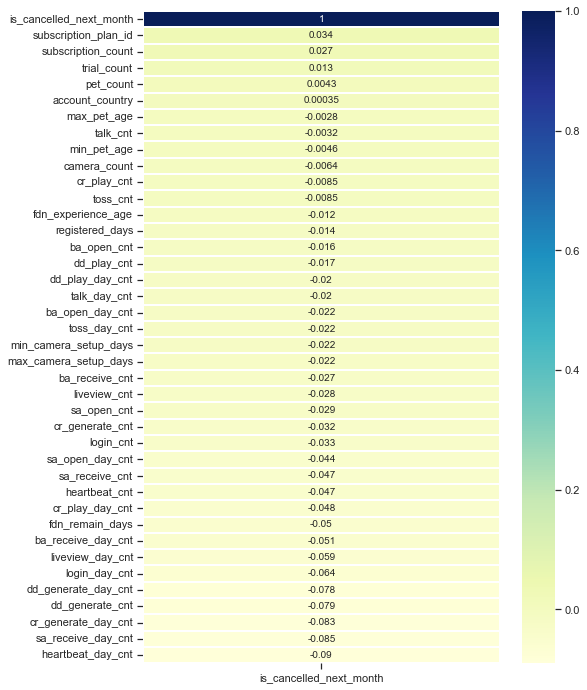

In [10]:
sns.set(style='ticks', color_codes=True)
plt.figure(figsize=(8, 12))
sns.heatmap(df_tree.corr()[['is_cancelled_next_month']].sort_values(by='is_cancelled_next_month', ascending=False), cmap='YlGnBu', linewidths=0.1, linecolor='w', annot=True)
plt.show()

### Linear

#### Take 70% data for training, 30％ for testing (fix the random state !!!)

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df_linear.iloc[:, : -1], df_linear.iloc[:, -1], test_size=0.3, random_state=0)


#### Oversampling for imbalanced data

In [20]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=77)
x_train, y_train = sm.fit_resample(x_train, y_train)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#### SGDRegression

In [21]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler


# Normalize
normalizer = StandardScaler()
normalizer.fit(x_train)
x_train_norm = normalizer.transform(x_train)
x_test_norm = normalizer.transform(x_test)


# Train
clf = SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                    early_stopping=False, epsilon=0.1, eta0=0.1, fit_intercept=True,
                    l1_ratio=0.15, learning_rate='constant', loss='log_loss',
                    max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
                    power_t=0.5, random_state=0, shuffle=True, tol=0.001,
                    validation_fraction=0.1, verbose=0, warm_start=False)
clf.fit(x_train_norm, y_train)




SGDClassifier(eta0=0.1, learning_rate='constant', loss='log_loss',
              random_state=0)

In [22]:
# from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


def binarize_predict(_y_pred, thresh=0.5):
    return (_y_pred > thresh).astype(int)


# accuracy_train = accuracy_score(binarize_predict(clf.predict(x_train_norm)), y_train)
# accuracy_test = accuracy_score(binarize_predict(clf.predict(x_test_norm)), y_test)

print('Training:')
print(classification_report(y_train,binarize_predict(clf.predict(x_train_norm))))
print('Testing:')
print(classification_report(y_test,binarize_predict(clf.predict(x_test_norm))))

# print('training accuracy: {:4f}, testing accuracy: {:4f}'.format(accuracy_train, accuracy_test))


Training:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93     47823
           1       0.95      0.91      0.93     47823

    accuracy                           0.93     95646
   macro avg       0.93      0.93      0.93     95646
weighted avg       0.93      0.93      0.93     95646

Testing:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     20529
           1       0.07      0.08      0.08       906

    accuracy                           0.91     21435
   macro avg       0.52      0.52      0.52     21435
weighted avg       0.92      0.91      0.92     21435



#### Importance

In [ ]:
importance = clf.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d.%60s Score: %.5f' % (i,df_linear.columns[i],v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()


### Trees

#### Take 70% data for training, 30％ for testing (fix the random state !!!)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df_tree.iloc[:, : -1], df_tree.iloc[:, -1], test_size=0.3, random_state=0)


#### Oversampling for imbalanced data

In [ ]:
sm = SMOTE(random_state=7)
x_train, y_train = sm.fit_resample(x_train, y_train)

x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

#### XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier


max_depth = 10
max_estimator = 150
learning_rate = 1
min_child_weight = 0 # force fitting training

model = XGBClassifier(scale_pos_weight=3,min_child_weight=min_child_weight, learning_rate=learning_rate, max_depth=max_depth, random_state=0, n_estimators=max_estimator)
model.fit(x_train, y_train.ravel(), eval_set=[(x_train, y_train.ravel()), (x_test, y_test.ravel())], eval_metric='error', verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(range(1, max_estimator+1), results['validation_0']['error'], '-o', label='train_errors')
ax.plot(range(1, max_estimator+1), results['validation_1']['error'], '-o', label='test_errors')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.1)
plt.xlabel('n_estimator')
plt.ylabel('error rate')
plt.show()

In [ ]:
print('Training:')
print(classification_report(y_train,binarize_predict(model.predict(x_train))))
print('Testing:')
print(classification_report(y_test,binarize_predict(model.predict(x_test))))